In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## L96 stuff

In [3]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import gym

In [4]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')

In [5]:
class L96TwoLevelRL(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step_with_B(self, B):

        k1_X = self._rhs_X_dt(self.X, B=0)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=0)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=0)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=0)

        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        
        self.X += B * self.dt

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())

In [6]:
class L96Gym(gym.Env):
    def __init__(self, lead_time, X_init, Y_init, dt=0.01, action_bounds=(-20,20)):
        self.lead_time = lead_time
        self.X_init, self.Y_init = X_init, Y_init
        self.step_count = 0
        self.dt = dt
        self.nsteps = self.lead_time // self.dt
        
        self.l96_tru = L96TwoLevel(X_init=initX, Y_init=initY)
        self.l96_tru.iterate(lead_time)
        self.fc_target = self.l96_tru.X.copy()
        
        self.action_space = gym.spaces.Box(
            low=np.array([action_bounds[0]]), 
            high=np.array([action_bounds[1]])
        )
        self.observation_space = gym.spaces.Box(-np.array([np.inf]), np.array([np.inf]))
        
    
    def reset(self):
        self.l96 = L96TwoLevelRL(noYhist=True, X_init=initX, dt=self.dt)
        state = self.l96.X
        return state[:, None]
    
    def step(self, action):
        self.l96.step_with_B(action)
        state = self.l96.X
        self.step_count += 1
        if self.step_count >= self.nsteps:
            done = True
            reward = -((state - self.fc_target)**2).mean()
        else:
            done = False
            reward = 0
        return state[:, None], reward, done, None

<h2>Use CUDA</h2>

In [7]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Replay Buffer</h2>

In [8]:
class ReplayBufferOld:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [9]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        if state.ndim == 1:
            self.buffer.append([state, action, reward, next_state, done])
        else:
            for i in range(len(state)):
                self.buffer.append([
                    state[i].squeeze(), action[i].squeeze(), reward, next_state[i].squeeze(), done])
#             for s, a, ns in zip(state, action, next_state):
#                 self.buffer.append([s, a, reward, ns, done])
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

<h2>Normalize action space</h2>

In [10]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def _reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

<h2>Ornstein-Uhlenbeck process</h2>
Adding time-correlated noise to the actions taken by the deterministic policy<br>
<a href="https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process">wiki</a>

In [11]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [12]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1> Continuous control with deep reinforcement learning</h1>
<h2><a href="https://arxiv.org/abs/1509.02971">Arxiv</a></h2>

In [13]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0, 0]
    
class PolicyNetworkLinear(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, num_actions)
        aelf.linear1.weight.data.uniform_(-init_w, init_w)
        self.linear1.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        return self.linear1(state)
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0, 0]

<h2>DDPG Update</h2>

In [14]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [15]:
env = NormalizedActions(gym.make("MountainCarContinuous-v0"))
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [16]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

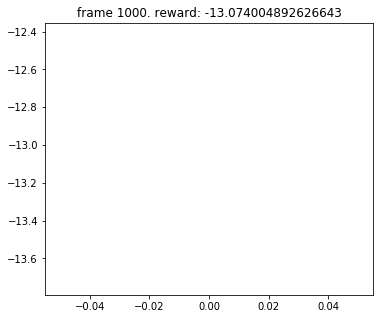

KeyboardInterrupt: 

In [17]:
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

In [ ]:
done = False
state=env.reset()
env.render()
while not done:
    action = policy_net.get_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    env.render()
env.close()

## L96 Version

In [18]:
env = NormalizedActions(L96Gym(1, initX, initY))
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [19]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

In [ ]:
policy_net.get_action

In [22]:
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state.squeeze()[None])
        action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

RuntimeError: size mismatch, m1: [1 x 36], m2: [1 x 256] at /Users/distiller/project/conda/conda-bld/pytorch_1556653464916/work/aten/src/TH/generic/THTensorMath.cpp:961

In [21]:
%debug

> <ipython-input-9-54d08f596be5>(11)push()
      9             for i in range(len(state)):
     10                 self.buffer.append([
---> 11                     state[i].squeeze(), action[i].squeeze(), reward, next_state[i].squeeze(), done])
     12 #             for s, a, ns in zip(state, action, next_state):
     13 #                 self.buffer.append([s, a, reward, ns, done])

ipdb> action
array([0.05827501])
ipdb> u
> <ipython-input-20-9de3efe19b71>(11)<module>()
      9         next_state, reward, done, _ = env.step(action)
     10 
---> 11         replay_buffer.push(state, action, reward, next_state, done)
     12         if len(replay_buffer) > batch_size:
     13             ddpg_update(batch_size)

ipdb> action
array([0.05827501])
ipdb> state
array([[ 7.13482625],
       [ 3.13563964],
       [ 1.50764469],
       [ 3.4558074 ],
       [ 3.56768157],
       [-2.85738061],
       [ 5.34980682],
       [ 6.16399497],
       [ 2.37294842],
       [ 4.69939535],
       [ 6.411

In [95]:
state

array([ 7.02781445,  3.02862784,  1.40063289,  3.3487956 ,  3.46066977,
       -2.96439241,  5.24279503,  6.05698318,  2.26593662,  4.59238355,
        6.30453636,  0.62071917, -5.66738443,  0.62357503,  8.4952498 ,
        3.96006677,  0.72454022, -2.05927756, -2.12564378,  3.9601194 ,
        5.89358173,  1.69029217, -1.15788812, -1.24739075,  5.04184687,
        4.38927059,  3.80052171,  2.16721125, -0.9207536 , -2.81227227,
        6.38110634,  5.31734142,  3.86684513,  1.4115378 , -1.57687204,
       -2.89394206])

In [88]:
state, action, reward, next_state, done = replay_buffer.sample(batch_size)

In [90]:
state.shape, reward.shape

((128, 36), (128,))